### Notebook to test out all different Dropout ratios for the Value Model

In [1]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from trial_splitters.kfold_splitter import KFoldSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import pickle

from models.value_models import ValueNormedModel, ValueNormedDropoutModel
from models.model_wrapper import ModelWrapper

from models.trainer import Trainer

import torch

import plotly.express as px


matplotlib.rcParams['figure.dpi'] = 150


species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500

In [2]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)

In [4]:
behavior_data.columns

Index(['TrialNumber', 'BlockNumber', 'TrialAfterRuleChange', 'TaskInterrupt',
       'ConditionNumber', 'Response', 'ItemChosen', 'TrialType', 'CurrentRule',
       'LastRule', 'ShiftType', 'Perseveration', 'TrialStart', 'FixCrossOn',
       'FixationOnCross', 'FixRequireEnd', 'StimOnset', 'FeedbackEncode',
       'FeedbackOnset', 'TrialEnd', 'Item0_xPos', 'Item0_yPos', 'Item1_xPos',
       'Item1_yPos', 'Item2_xPos', 'Item2_yPos', 'Item3_xPos', 'Item3_yPos',
       'Item0Shape', 'Item0Color', 'Item0Pattern', 'Item1Shape', 'Item1Color',
       'Item1Pattern', 'Item2Shape', 'Item2Color', 'Item2Pattern',
       'Item3Shape', 'Item3Color', 'Item3Pattern'],
      dtype='object')

In [ ]:
firing_rates = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_1300_fb_1500_100_bins.pickle"))

In [9]:
for p_dropout in np.arange(0.5, 0.6, 0.1):
    p_dropout_str = str(p_dropout).replace(".", "p")
    num_neurons = len(firing_rates.UnitID.unique())
    labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
    init_params = {"n_inputs": num_neurons, "n_values": 12, "p_dropout": p_dropout}
    # init_params = {"n_inputs": num_neurons, "n_values": 12}

    trainer = Trainer(learning_rate=0.05, max_iter=500, batch_size=256)
    wrapped = ModelWrapper(ValueNormedDropoutModel, init_params, trainer, labels)
    # wrapped = ModelWrapper(ValueNormedModel, init_params, trainer, labels)

    mode = "SpikeCounts"

    # prep data for classification
    inputs = firing_rates.rename(columns={mode: "Value"})
    labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

    random_splitter = KFoldSplitter(labels.TrialNumber.unique(), 5)

    train_accs_by_bin, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
        wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter, cards=shuffled_card_idxs
    )
    # np.save(fs.open(f"l2l.pqz317.scratch/value_model_dropout_{p_dropout_str}_train_accs_{pre_interval}_fb_{post_interval}_by_bin_kfold_split.npy", "wb"), train_accs_by_bin)
    # np.save(fs.open(f"l2l.pqz317.scratch/value_model_dropout_{p_dropout_str}_accs_{pre_interval}_fb_{post_interval}_by_bin_kfold_split.npy", "wb"), test_accs_by_bin)
    # np.save(fs.open(f"l2l.pqz317.scratch/value_model_dropout_{p_dropout_str}_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_kfold_split.npy", "wb"), shuffled_accs)
    # np.save(fs.open(f"l2l.pqz317.scratch/value_model_dropout_{p_dropout_str}_models_{pre_interval}_fb_{post_interval}_by_bin_kfold_split.npy", "wb"), models)
    # pickle.dump(splits, fs.open(f"l2l.pqz317.scratch/value_model_dropout_{p_dropout_str}_splits_{pre_interval}_fb_{post_interval}_by_bin_kfold_split.npy", "wb"))

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7


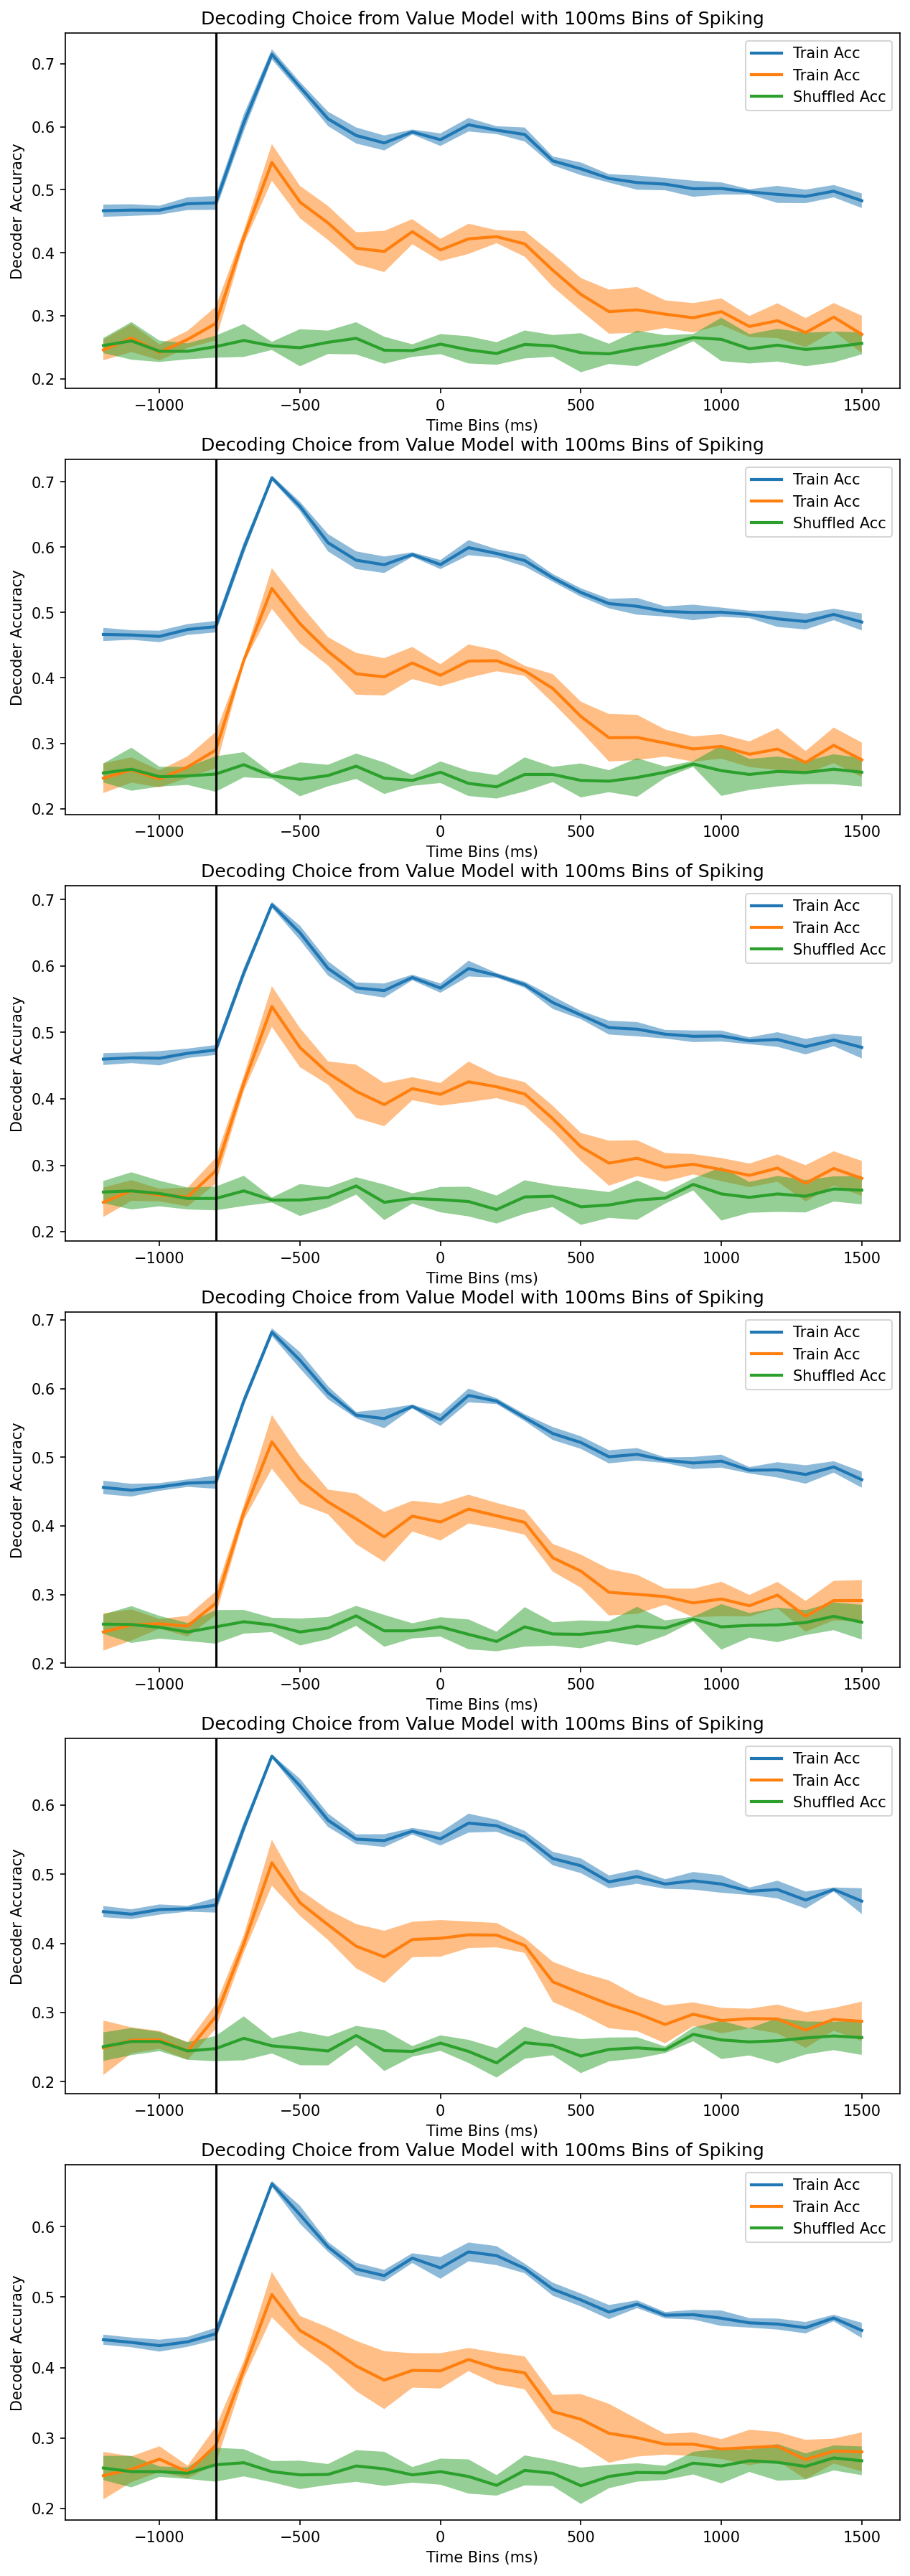

In [6]:
# generate figures
fig, axs = plt.subplots(6, 1, figsize=(10, 30))

for i, p_dropout in enumerate(np.arange(0.0, 0.6, 0.1)):
    p_dropout_str = str(p_dropout).replace(".", "p")
    train_accs_by_bin = np.load(fs.open(f"l2l.pqz317.scratch/value_model_dropout_{p_dropout_str}_train_accs_{pre_interval}_fb_{post_interval}_by_bin_kfold_split.npy", "rb"))
    test_accs_by_bin = np.load(fs.open(f"l2l.pqz317.scratch/value_model_dropout_{p_dropout_str}_accs_{pre_interval}_fb_{post_interval}_by_bin_kfold_split.npy", "rb"))
    shuffled_accs = np.load(fs.open(f"l2l.pqz317.scratch/value_model_dropout_{p_dropout_str}_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_kfold_split.npy", "rb"))

    visualization_utils.visualize_accuracy_across_time_bins(
        train_accs_by_bin,
        pre_interval, post_interval, 100,
        axs[i],
        label="Train Acc",
        right_align=True
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs_by_bin,
        pre_interval, post_interval, 100,
        axs[i],
        label="Train Acc",
        right_align=True
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        shuffled_accs,
        pre_interval, post_interval, 100,
        axs[i],
        label="Shuffled Acc",
        right_align=True
    )

    axs[i].axvline(-800, color='k')
    axs[i].set_xlabel("Time Bins (ms)")
    axs[i].set_ylabel("Decoder Accuracy")
    axs[i].set_title(f"Decoding Choice from Value Model with 100ms Bins of Spiking")
    axs[i].legend()

### Conclusions: 
Seems like dropouts might not make a difference because number of neurons firing is so low to begin with